In [1]:
# matplotlib 한글 폰트 적용
# 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,736 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

import os
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)


In [3]:
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'NanumBarunGothic'
mpl.rcParams['axes.unicode_minus'] = False

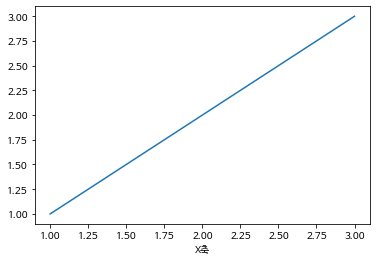

In [4]:
# 한글 되는지 확인
plt.plot([1,2,3], [1,2,3])
plt.xlabel('X축')
plt.show()

# 데이터 로딩

In [5]:
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()
train_image.shape, test_image.shape


170498071/170498071 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
class_names = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭'])

# 이미지 확인
- matplotlib을 이용해 N개의 이미지를 확인한다. 
    - 개수는 알아서 선택하세요.

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


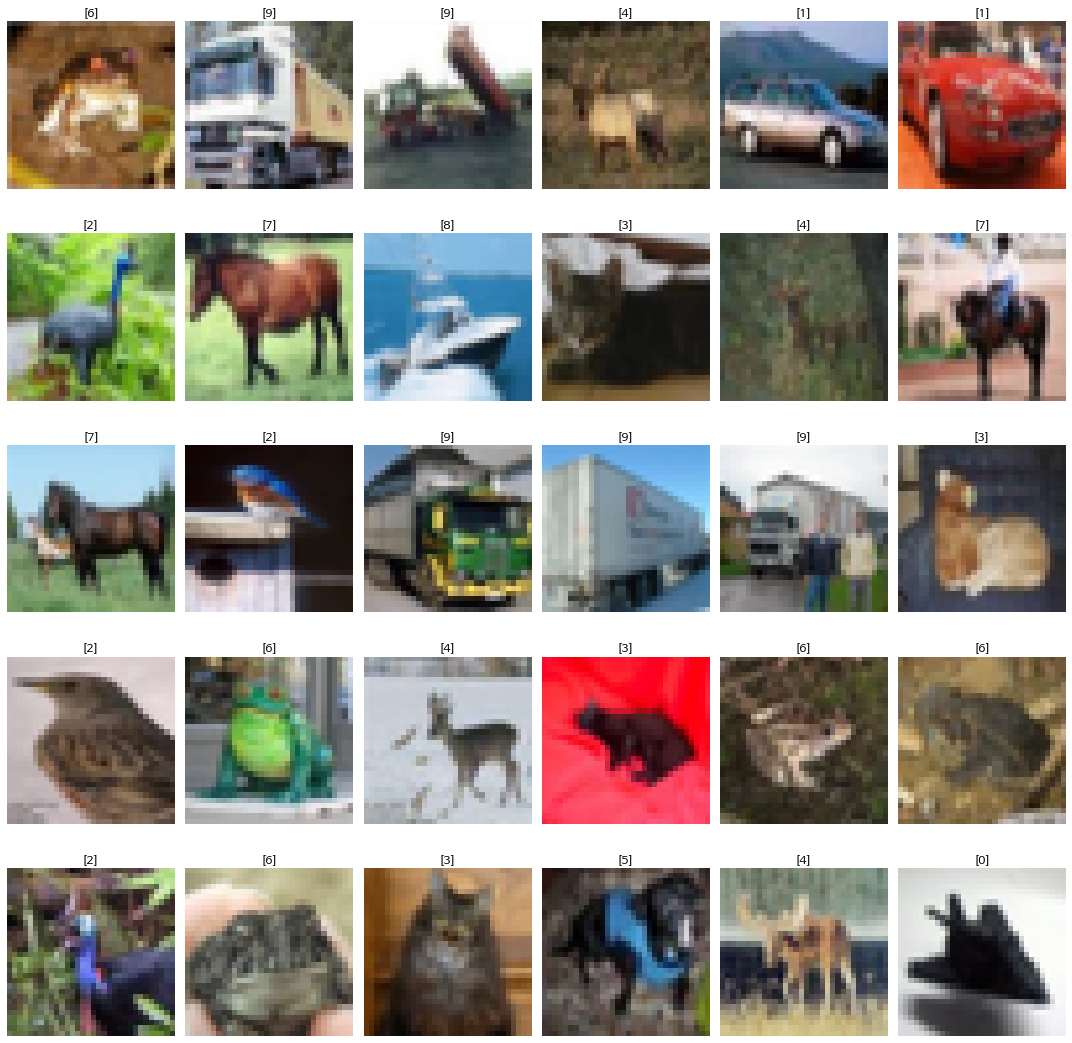

In [7]:
plt.figure(figsize=(15,15))
for i in range(30):
  plt.subplot(5,6,i+1)
  plt.imshow(train_image[i])
  plt.title(train_label[i])
  plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
# 시각과 함수 정의
def plot_result(hist, loss_min=None, loss_max=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(hist.epoch, hist.history['loss'], label='Train Loss')
    plt.plot(hist.epoch, hist.history['val_loss'], label='Validation Loss')
    plt.title("Loss")
    # if loss_min!=None and loss_max!=None:
    #     plt.ylim(loss_min, loss_max)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.epoch, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.epoch, hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 데이터 전처리
- X: 0 ~ 1 scaling
- y: onehot encoding

In [8]:
# input 전처리
X_train = train_image.astype('float32')/255
X_train = X_train[..., np.newaxis] # reshape(28,28,-1)

X_test = test_image.astype('float32')/255
X_test = X_test[..., np.newaxis]

print(X_train.dtype, X_test.dtype)
print(X_train.shape, X_test.shape)

float32 float32
(50000, 32, 32, 3, 1) (10000, 32, 32, 3, 1)


In [9]:
# output 전처리 -> One Hot Encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

print(train_label.shape, y_train.shape)
print(test_label.shape, y_test.shape)

(50000, 1) (50000, 10)
(10000, 1) (10000, 10)


# 하이퍼파라미터, 변수 정의

In [11]:
LEARNING_RATE=0.001
N_EPOCH = 250
N_BATCH = 256

N_TRAIN = X_train.shape[0]

# Dataset 생성
- train/test set

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

# 모델 생성 및 컴파일
- CNN 모델을 이용해 10개의 class를 분류하는 모델을 구현

In [13]:
def get_cifar10_cnn_model(lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))

    # Feature Extractor -> Convolution Block (Conv + MaxPool)
    model.add(layers.Conv2D(filters=32,         # 레이어의 필터 개수.
                           kernel_size=(3,3),  # 필터의 크기(height, width). height와 width가 같은 경우 정수로 지정.
                           strides=(1,1),      # stride 지정 (좌우, 상하) 이동크기.(기본: (1, 1)). 두 값이 같은 경우 정수
                           padding='same',     # 패딩방식 - "same": input/output의 shape이 같도록 처리. "valid"-기본값: 패딩 안씀
                           activation='relu'   # 활성함수.
                           ))
    # MaxPooing Layer을 이용해서 Feature map의 size를 줄여준다. 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), # Max값을 추출할 영역의 크기(height, width) => 기본: (2, 2) => 절반으로 줄인다.
                                  strides=(2, 2),   # 이동 간격. 튜플:(좌우, 상하) 정수: 두값이 같은 경우 정수로 설정. 기본값: pool_size와 동일하게 잡아준다.(겹치지 않도록 하기 위해.)
                                  padding="same"    # "same": 추출하려는 영역의 크기가 pool_size보다 작아도 max값을 추출.
                                  ))                # "valid" (기본): 추출하려는 영역의 크기가 pool_size보다 작으면 max값을 추출하지 않는다.

    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Dropout(0.25))

    # Filter Map(3차원) -> 1차원으로 reshape
    model.add(layers.Flatten())  
    # Dense Layer 추가
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=256, activation='relu'))
    # 출력
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))

    # 컴파일 
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
model = get_cifar10_cnn_model(LEARNING_RATE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

#### 학습

In [15]:
hist = model.fit(train_dataset, epochs=N_EPOCH, validation_data=test_dataset)

Epoch 1/250
195/195 [==============================] - 16s 17ms/step - loss: 2.0857 - accuracy: 0.1886 - val_loss: 1.7523 - val_accuracy: 0.3213
Epoch 2/250
195/195 [==============================] - 2s 12ms/step - loss: 1.7170 - accuracy: 0.3295 - val_loss: 1.5258 - val_accuracy: 0.4145
Epoch 3/250
195/195 [==============================] - 2s 12ms/step - loss: 1.5580 - accuracy: 0.4094 - val_loss: 1.4069 - val_accuracy: 0.4709
Epoch 4/250
195/195 [==============================] - 2s 12ms/step - loss: 1.4426 - accuracy: 0.4663 - val_loss: 1.2463 - val_accuracy: 0.5381
Epoch 5/250
195/195 [==============================] - 3s 14ms/step - loss: 1.3487 - accuracy: 0.5131 - val_loss: 1.2163 - val_accuracy: 0.5624
Epoch 6/250
195/195 [==============================] - 3s 13ms/step - loss: 1.2790 - accuracy: 0.5417 - val_loss: 1.1589 - val_accuracy: 0.5814
Epoch 7/250
195/195 [==============================] - 3s 13ms/step - loss: 1.2251 - accuracy: 0.5641 - val_loss: 1.0655 - val_accuracy

#### 결과 시각화

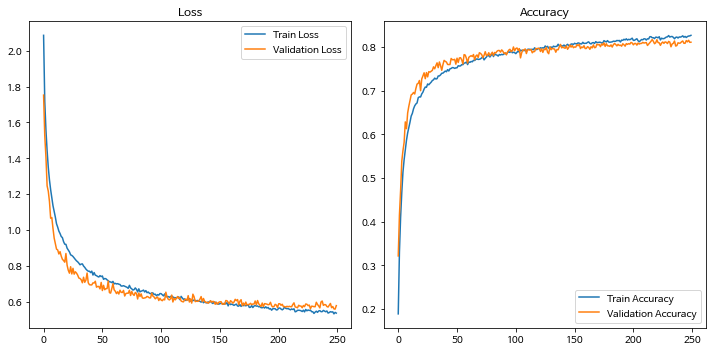

In [28]:
plot_result(hist, 0, 0.05)

#### 최종검증

In [26]:
loss, acc = model.evaluate(test_dataset)
print(loss, acc)

40/40 [==============================] - 0s 8ms/step - loss: 0.5782 - accuracy: 0.8108
0.5782308578491211 0.8108000159263611


### prediction error가 발생한 data 확인
  - test dataset으로 예측한 결과 중 틀린 것들을 확인해 본다.

In [18]:
X_test.shape

(10000, 32, 32, 3, 1)

In [19]:
pred = model.predict(X_test)
pred.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

In [20]:
label = np.argmax(pred, axis=-1)   #모델이 추론한 label
print(label.shape)
label[:5]

(10000,)


array([3, 8, 8, 8, 6])

In [21]:
# 모델이 추론한 결과중 정답과 다른 것의 index를 조회
fail_idx = np.where(test_label != label)[0]
fail_idx.size

90000000

### confusion matrix 확인



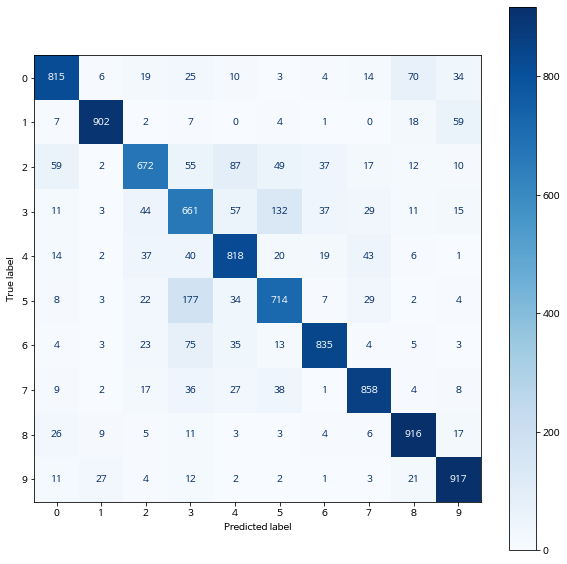

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10,10))
ax = plt.gca() #크게 보려고 설정

cm = confusion_matrix(test_label, label)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap="Blues", ax=ax)
plt.show()

In [29]:
# 틀린 이미지 출력
# plt.figure(figsize=(10,10))
# rows = int(np.ceil(fail_idx.size/10)) # 10개 행 만듦
# print(rows)

# for i in range(int(fail_idx.size)):   # 틀린 것 개수만큼 반복
#   error_idx = fail_idx[i]
#   pred_label = label[error_idx] # 틀린 것에 대해 모델이 예측한 라벨
#   true_label = test_label[error_idx] # 틀린 것에 대한 정답 라벨
#   img = test_image[error_idx]

#   plt.subplot(10, rows, i+1)
#   plt.imshow(img, cmap="gray")
#   plt.title(f"True: {true_label}, Pred: {pred_label}")
#   plt.axis('off')

# plt.tight_layout()
# plt.show()

9000000


KeyboardInterrupt: ignored

# 학습 및 평가
- callback을 이용해 early stopping, 가장 성능 좋았을때 모델 저장 하세요.
    - 모델은 자신의 google drive에 저장하세요.
- 저장됬던 모델을 loading한 뒤 그 모델도 평가해보세요.